#### **Import Libraries**

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt
from datasets import Dataset
import transformers
from torch.utils.data import DataLoader
import numpy as np 
import torch
from torch import nn
from trics.nlp.generate import generate_dataset
from trics.nlp.train import EarlyStopping, evaluate_model, train_one_epoch, predict

#### **Set Up Device**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [3]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

512


#### **Dataset**

In [4]:
# original_dataset = Dataset.from_dict(generate_dataset(total_entries=1000, flip_rate=0.))
# dataset = original_dataset.train_test_split(test_size=0.5, seed=42)
# tokenized_dataset = dataset.map(tokenizer_function, batched=True)
# tokenized_dataset = tokenized_dataset.remove_columns("text")

original_dataset = load_dataset("ppower1/instrument")['train']
subset_dataset = original_dataset.shuffle(seed=42).select(range(7000))
dataset = subset_dataset.train_test_split(test_size=0.5, seed=42)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'treated text', 'control text', 'raw_label'])

def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

max(dataset['train'].map(count_tokens)['num_tokens'])

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


937

#### **Hyperparameters**

In [5]:
batch_size = 16
epochs = 20

#### **DataLoaders**

In [6]:
train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_id)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and scheduler**

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(0.1*len(train_loader)*epochs), len(train_loader)*epochs)

Relative Weights: tensor([0.5000, 0.5000], device='cuda:0')


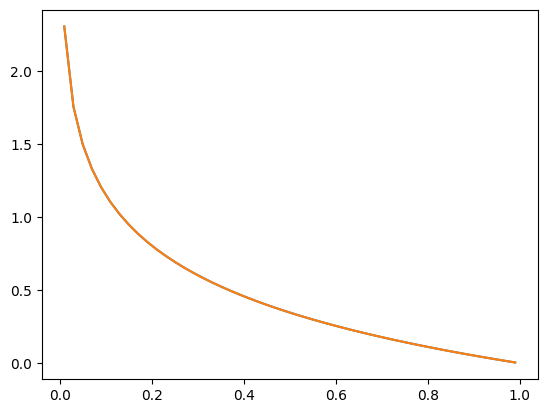

In [9]:
# Assume 'class_counts' is a list containing the number of samples for each class
total_samples = sum(original_dataset['label'])
class_weights = torch.tensor([0.5, 0.5], device=device) #torch.tensor([total_samples/ len(original_dataset), 1-total_samples/ len(original_dataset)], device=device)
print(f"Relative Weights: {class_weights}")

# Create a weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

ps = np.linspace(0.01, 0.99)
ys0 = -1.0*class_weights[0].cpu()*np.log(ps)
ys1 = -1.0*class_weights[1].cpu()*np.log(ps)
plt.plot(ps, ys0)
plt.plot(ps, ys1)
plt.show()

#### **Training**

In [10]:
evaluation_losses = [evaluate_model(model, test_loader, device)]
training_losses = [evaluate_model(model, train_loader, device)]
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in range(epochs):

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    training_losses.append(train_loss)
    
    val_loss = evaluate_model(model, test_loader, device)
    evaluation_losses.append(val_loss)
    
    # Call early stopping
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

model.load_state_dict(torch.load('checkpoint.pt'))


Validation loss decreased (inf --> 0.220582).  Saving model ...
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping


<All keys matched successfully>

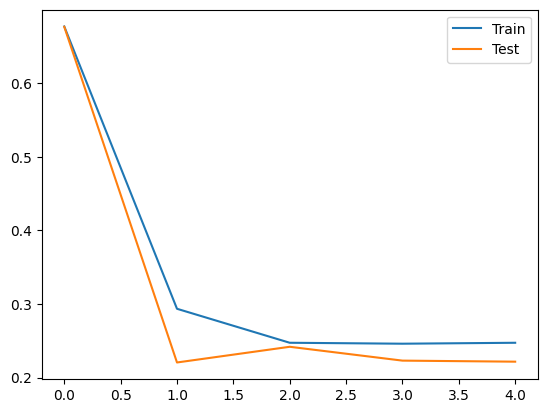

In [11]:
plt.plot(training_losses, label='Train')
plt.plot(evaluation_losses, label='Test')
plt.legend()
plt.show()

In [12]:
yhat = predict(model, train_loader, device)

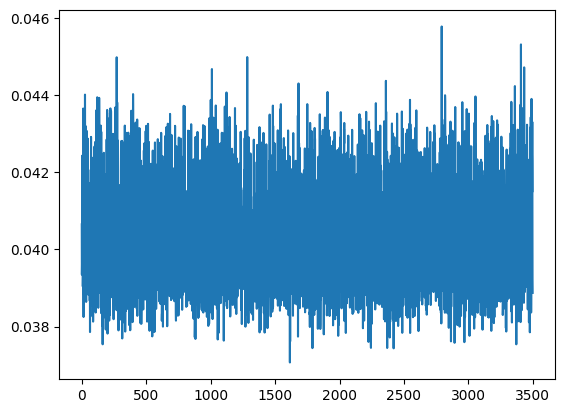

In [15]:
plt.plot(yhat)